In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP
import HDF5
using Optim

In [42]:
include("../model-41/likelihood.jl")
include("../model-41/utill_model.jl")
include("../utill.jl")

plot_projections (generic function with 1 method)

In [3]:
function hist_2d(smpls, dim_1, dim_2; nbins=35, axmin = true, axmax=true)
    smpl_tmp, smpl_w = flatview(unshaped.(smpls.v)), smpls.weight
    if axmin == true
        hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), nbins=nbins)
    else
       hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), (range(axmin[1], stop=axmax[1], length=nbins), range(axmin[2], stop=axmax[2], length=nbins))) 
    end
    hist_tmp = normalize(hist_tmp, mode=:pdf) 
    return hist_tmp
end

hist_2d (generic function with 1 method)

In [15]:
β1= 0.015
β2 = 0.0077
β3 = 0.0058 

function trunc_norm(m, sgm; alpha=2)
    return truncated(Normal(m, sgm), m - alpha*sgm, m + alpha*sgm)
end

prior_1 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), truncated(Normal(4.0, 2.0), 1.0, 8.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
        mixt_pow =  0.55 .. 1.0, 
        waist = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        waist_2 = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
)

prior_2 = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)],
        ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), truncated(Normal(4.0, 2.0), 1.0, 8.0)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
        mixt_pow =  0.35 .. 1.0, 
        waist = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        waist_2 = [truncated(Normal(2.9, 0.03), 2.6, 3.6)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1., 1, 1], # 23, 24, 25, 
        resy = [1., 1, 1], # 26,27, 28, 
        cam4_resx = 1.0,
        cam4_resy = 1.0, 
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
);

In [16]:
FPATH = "../../data/sampling_results/Benchmark-13/"

"../../data/sampling_results/Benchmark-13/"

In [17]:
smpl_tmp = bat_read(FPATH*"samples-varying-res.hdf5").result
samples_1 = varshape(prior_1).(smpl_tmp)

smpl_tmp = bat_read(FPATH*"samples-res-1.hdf5").result
samples_2 = varshape(prior_2).(smpl_tmp);

In [19]:
[size(flatview(unshaped.(samples_1.v))), size(flatview(unshaped.(samples_2.v)))]

2-element Array{Tuple{Int64,Int64},1}:
 (27, 472740)
 (25, 464377)

In [20]:
mean(samples_1)

ShapedAsNT((tr_size = [0.08962601138344506, 0.13279630723247132], tr_size_2 = [0.13176412236025195, 0.15265933363053544], ang_spr = [6.222935137678962, 5.759259167363568], ang_spr_2 = [2.6004905693890294, 2.37937277242284], mixt_pow = 0.6650873464726307, waist = [3.140648350631113], waist_2 = [2.851222569839136], algmx = [31.737375636142627, 32.2193260827561, 21.298441230385254, 35.238376441542925], algmy = [36.94028911189161, 37.42826789293065, 20.231468383701507, 33.90526581056345], cam4_ped = 27.550523204886506, cam4_light_fluct = 1.36226257155492, cam4_light_amp = 8.843984048943048, resx = [1, 1, 1], resy = [1, 1, 1], cam4_resx = 4.830213813714564, cam4_resy = 4.773588815370763, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.528135071306414, 11.423120951474125, 2.6882977005416464], s_cam = [0.0, 1.478, 15.026, 23.115]))

In [21]:
mean(samples_2)

ShapedAsNT((tr_size = [0.1000235197235618, 0.13878702151920194], tr_size_2 = [0.1251745327717931, 0.14658982593784445], ang_spr = [6.72067950275378, 6.266494319431501], ang_spr_2 = [3.6656651809779084, 3.49388046422186], mixt_pow = 0.6822210254660298, waist = [2.8415640102768687], waist_2 = [2.816311282593922], algmx = [31.741265409917727, 32.20609235147525, 21.465093615507758, 35.2347112267561], algmy = [36.95388655979266, 37.426059480489315, 20.3093380114427, 33.91348081953358], cam4_ped = 27.65124472889483, cam4_light_fluct = 1.3559642257975868, cam4_light_amp = 8.864559182926735, resx = [1.0, 1.0, 1.0], resy = [1.0, 1.0, 1.0], cam4_resx = 1.0, cam4_resy = 1.0, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.403599321015642, 11.35999955898119, 2.1290539375592172], s_cam = [0.0, 1.478, 15.026, 23.115]))

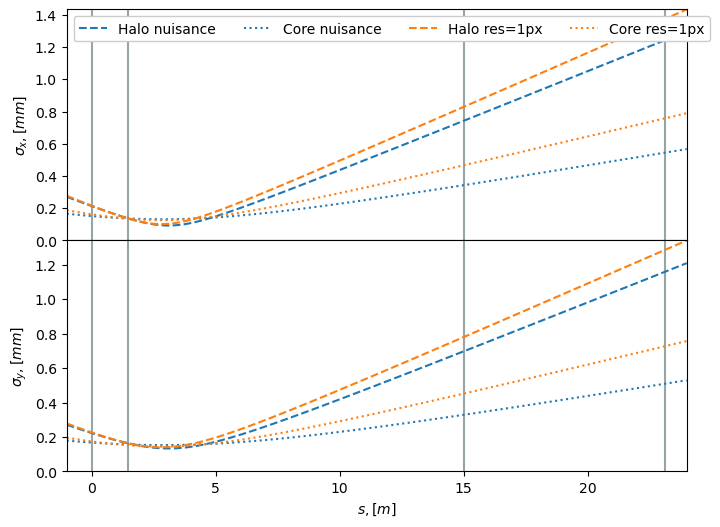

PyObject Text(0.5, 26.28125, '$s, [m]$')

In [47]:
params_array = [mode(samples_1)[1], mode(samples_2)[1]]
colors_array = ["C0", "C1"]
labels_array = [" nuisance", " res=1px", "Mean"]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

In [25]:
function plot_contour(ax, hist; kwargs...)
    ax.contour(midpoints(hist.edges[1]), midpoints(hist.edges[2]), hist.weights', 
        levels=range(minimum(hist.weights'), maximum(hist.weights'), length=8)[2:end]; #corner_mask= true,
        kwargs..., antialiased=true) 
end

function plot_contourf(ax, hist; kwargs...)
    ax.contourf(midpoints(hist.edges[1]), midpoints(hist.edges[2]), hist.weights', 
        levels=range(minimum(hist.weights'), maximum(hist.weights'), length=8)[2:end]; #corner_mask= true,
        kwargs..., antialiased=true) 
end

plot_contourf (generic function with 1 method)

In [27]:
hist_211 = hist_2d(samples_1, 1,2)
hist_212 = hist_2d(samples_1, 3,4)

hist_221 = hist_2d(samples_2, 1,2)
hist_222 = hist_2d(samples_2, 3,4);

In [28]:
# custom_cmaps: 

clist = [(0,"white"), (1, "#1b9e77")] #green
cmap_3 = matplotlib.colors.LinearSegmentedColormap.from_list("my_cmap", clist)
col_3 = "#1b9e77"

clist = [(0,"white"), (1, "#d95f02")] #orange
cmap_1 = matplotlib.colors.LinearSegmentedColormap.from_list("my_cmap", clist)
col_1 = "#d95f02"

clist = [(0,"white"), (1, "#7570b3")] # violet
cmap_2 = matplotlib.colors.LinearSegmentedColormap.from_list("my_cmap", clist)
col_2 = "#7570b3"

"#7570b3"

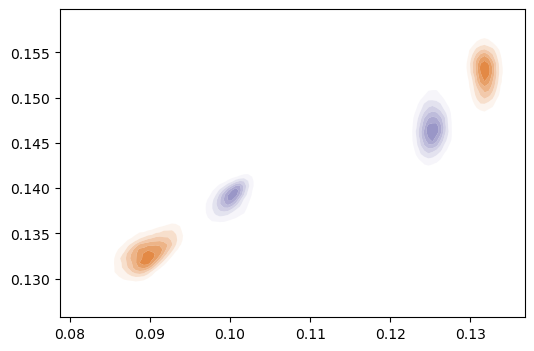

PyObject <matplotlib.contour.QuadContourSet object at 0x7faa6fb65100>

In [32]:
fig, (ax) = plt.subplots(1,1, figsize=(6,4))

plot_contourf(ax, hist_211, cmap=cmap_1, alpha=0.8, )
plot_contourf(ax, hist_212, cmap=cmap_1, alpha=0.8,)

plot_contourf(ax, hist_221, cmap=cmap_2, alpha=0.8, )
plot_contourf(ax, hist_222, cmap=cmap_2, alpha=0.8,)

In [ ]:
min_vals = -73700.38088631934

i_11 = [-73649.38088631934, -73651.6982440232] .- min_vals
i_12 = [-73538.94357576006, -73541.2350409309] .- min_vals
i_13 = [-73491.52053144189, -73494.37750708264] .- min_vals
i_21 = [-71980.00078991472, -71983.18498602472] .- min_vals
i_22 = [-71885.77803492927, -71887.9727737773] .- min_vals
i_23 = [-71880.08336777825, -71880.45707944027] .- min_vals

In [ ]:
labels = ["S1", "S2", "S3", "S1", "S2", "S3"]
lab_ind = 1:6

fig, (ax, ax2) = plt.subplots(1,2, figsize=(6,4), gridspec_kw=Dict("width_ratios"=>[2, 1]))
fig.subplots_adjust(hspace=0.0, wspace=0.05)

plot_contour(ax, hist_11, colors=col_1, linewidths=0.7, alpha=0.6, linestyles=:dotted)
plot_contour(ax, hist_12, colors=col_2, linewidths=0.7, alpha=0.6, linestyles=:dotted)
plot_contour(ax, hist_13, colors=col_3, linewidths=0.7, alpha=0.6, linestyles=:dotted)

# plot_contourf(ax, hist_11, cmap=:Blues, linewidths=0.8, alpha=0.5, )
# plot_contourf(ax, hist_12, cmap=:Oranges, linewidths=0.8, alpha=0.5,)
# plot_contourf(ax, hist_13, cmap=:Greens, linewidths=0.8, alpha=0.5,)

# 2G Model:

plot_contourf(ax, hist_231, cmap=cmap_3, alpha=0.8, )
plot_contourf(ax, hist_232, cmap=cmap_3, alpha=0.8,)
plot_contour(ax, hist_231, colors=col_3, linewidths=0.8, alpha=0.4, )
plot_contour(ax, hist_232, colors=col_3, linewidths=0.8, alpha=0.4, )

plot_contourf(ax, hist_221, cmap=cmap_2, alpha=0.8, )
plot_contourf(ax, hist_222, cmap=cmap_2, alpha=0.8,)
plot_contour(ax, hist_221, colors=col_2, linewidths=0.6, alpha=0.4, )
plot_contour(ax, hist_222, colors=col_2, linewidths=0.6, alpha=0.4, )

plot_contourf(ax, hist_211, cmap=cmap_1, alpha=0.8, )
plot_contourf(ax, hist_212, cmap=cmap_1, alpha=0.8,)
plot_contour(ax, hist_211, colors=col_1, linewidths=0.8, alpha=0.4, )
plot_contour(ax, hist_212, colors=col_1, linewidths=0.8, alpha=0.4,)

ax2.axhline(i_11[1], zorder=-100, linewidth=0.5, color=col_1, )
ax2.axhline(i_12[1], zorder=-100, linewidth=0.5, color=col_2, )
ax2.axhline(i_13[1], zorder=-100, linewidth=0.5, color=col_3, )

ax2.axhline(i_21[1], zorder=-100, linewidth=0.5, color=col_1, )
ax2.axhline(i_22[1], zorder=-100, linewidth=0.5, color=col_2, )
ax2.axhline(i_23[1], zorder=-100, linewidth=0.5, color=col_3, linestyle="--")

ax2.bar(1, i_11[1], width=0.7, color=:white, edgecolor=col_1, linestyle=":")
ax2.bar(2, i_12[1], width=0.7, color=:white, edgecolor=col_2, linestyle=":")
ax2.bar(3, i_13[1], width=0.7, color=:white, edgecolor=col_3, linestyle=":")

ax2.bar(1, i_11[1], width=0.7, color=col_1, edgecolor=col_1, alpha=0.1)
ax2.bar(2, i_12[1], width=0.7, color=col_2, edgecolor=col_2, alpha=0.1)
ax2.bar(3, i_13[1], width=0.7, color=col_3, edgecolor=col_3, alpha=0.1)

ax2.bar(4, i_21[1], width=0.7, color=:white, edgecolor=col_1,)
ax2.bar(5, i_22[1], width=0.7, color=:white, edgecolor=col_2,)
ax2.bar(6, i_23[1], width=0.7, color=:white, edgecolor=col_3,)

ax2.bar(4, i_21[1], width=0.7, color=col_1, edgecolor=col_1, alpha=0.6)
ax2.bar(5, i_22[1], width=0.7, color=col_2, edgecolor=col_2, alpha=0.6)
ax2.bar(6, i_23[1], width=0.7, color=col_3, edgecolor=col_3, alpha=0.6)

ax.plot(-10, 10, linestyle=":", color=col_1, label="1G, S1")
ax.plot(-10, 10, linestyle=":", color=col_2, label="1G, S2")
ax.plot(-10, 10, linestyle=":", color=col_3, label="1G, S3")
ax.plot(-10, 10, linestyle="-", color=col_1, label="2G, S1")
ax.plot(-10, 10, linestyle="-", color=col_2, label="2G, S2")
ax.plot(-10, 10, linestyle="-", color=col_3, label="2G, S3")
ax.legend(loc="lower right", framealpha=0.0)

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

ax2.set_xticks(lab_ind)
ax2.set_xticklabels(labels)

ax.set_xlim(0.067, 0.137)
ax.set_ylim(0.105, 0.16)

ax.set_xlabel(L"\sigma_x \; (\mathrm{mm})")
ax.set_ylabel(L"\sigma_y \; (\mathrm{mm})")
ax2.set_ylabel(L"\log(Z/Z_{ref})")

fig.text(0.71, 0.01, "1G Model", ha="center")
fig.text(0.835, 0.01, "2G Model", ha="center")

In [ ]:
labels = ["S1", "S2", "S3", "S1", "S2", "S3"]
lab_ind = 1:6

fig, (ax, ax2) = plt.subplots(1,2, figsize=(6,4), gridspec_kw=Dict("width_ratios"=>[2, 1]))
fig.subplots_adjust(hspace=0.0, wspace=0.05)

plot_contour(ax, hist_11, colors=:C3, linewidths=0.7, alpha=0.6, linestyles=:dotted)
plot_contour(ax, hist_12, colors=:C0, linewidths=0.7, alpha=0.6, linestyles=:dotted)
plot_contour(ax, hist_13, colors=:C2, linewidths=0.7, alpha=0.6, linestyles=:dotted)

# plot_contourf(ax, hist_11, cmap=:Blues, linewidths=0.8, alpha=0.5, )
# plot_contourf(ax, hist_12, cmap=:Oranges, linewidths=0.8, alpha=0.5,)
# plot_contourf(ax, hist_13, cmap=:Greens, linewidths=0.8, alpha=0.5,)

# 2G Model:

plot_contourf(ax, hist_231, cmap=:BuGn, alpha=0.8, )
plot_contourf(ax, hist_232, cmap=:BuGn, alpha=0.8,)
plot_contour(ax, hist_231, colors=:C2, linewidths=0.8, alpha=0.4, )
plot_contour(ax, hist_232, colors=:C2, linewidths=0.8, alpha=0.4, )

plot_contourf(ax, hist_221, cmap=:PuBu, alpha=0.8, )
plot_contourf(ax, hist_222, cmap=:PuBu, alpha=0.8,)
plot_contour(ax, hist_221, colors=:C0, linewidths=0.6, alpha=0.4, )
plot_contour(ax, hist_222, colors=:C0, linewidths=0.6, alpha=0.4, )

plot_contourf(ax, hist_211, cmap=:OrRd, alpha=0.8, )
plot_contourf(ax, hist_212, cmap=:OrRd, alpha=0.8,)
plot_contour(ax, hist_211, colors=:Red, linewidths=0.8, alpha=0.4, )
plot_contour(ax, hist_212, colors=:Red, linewidths=0.8, alpha=0.4,)

ax2.axhline(i_11[1], zorder=-100, linewidth=0.5, color=:C3, )
ax2.axhline(i_12[1], zorder=-100, linewidth=0.5, color=:C0, )
ax2.axhline(i_13[1], zorder=-100, linewidth=0.5, color=:C2, )

ax2.axhline(i_21[1], zorder=-100, linewidth=0.5, color=:C3, )
ax2.axhline(i_22[1], zorder=-100, linewidth=0.5, color=:C0, )
ax2.axhline(i_23[1], zorder=-100, linewidth=0.5, color=:C2, linestyle="--")

ax2.bar(1, i_11[1], width=0.7, color=:white, edgecolor=:C3, linestyle=":")
ax2.bar(2, i_12[1], width=0.7, color=:white, edgecolor=:C0, linestyle=":")
ax2.bar(3, i_13[1], width=0.7, color=:white, edgecolor=:C2, linestyle=":")

ax2.bar(1, i_11[1], width=0.7, color=:C3, edgecolor=:C3, alpha=0.1)
ax2.bar(2, i_12[1], width=0.7, color=:C0, edgecolor=:C0, alpha=0.1)
ax2.bar(3, i_13[1], width=0.7, color=:C2, edgecolor=:C2, alpha=0.1)

ax2.bar(4, i_21[1], width=0.7, color=:white, edgecolor=:C3,)
ax2.bar(5, i_22[1], width=0.7, color=:white, edgecolor=:C0,)
ax2.bar(6, i_23[1], width=0.7, color=:white, edgecolor=:C2,)

ax2.bar(4, i_21[1], width=0.7, color=:C3, edgecolor=:C3, alpha=0.6)
ax2.bar(5, i_22[1], width=0.7, color=:C0, edgecolor=:C0, alpha=0.6)
ax2.bar(6, i_23[1], width=0.7, color=:C2, edgecolor=:C2, alpha=0.6)

ax.plot(-10, 10, linestyle=":", color=:C3, label="1G, S1")
ax.plot(-10, 10, linestyle="-", color=:C3, label="2G, S1")
ax.plot(-10, 10, linestyle=":", color=:C0, label="1G, S2")
ax.plot(-10, 10, linestyle="-", color=:C0, label="2G, S2")
ax.plot(-10, 10, linestyle=":", color=:C2, label="1G, S3")
ax.plot(-10, 10, linestyle="-", color=:C2, label="2G, S3")
ax.legend(loc="lower right", framealpha=0.0)

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

ax2.set_xticks(lab_ind)
ax2.set_xticklabels(labels)

ax.set_xlim(0.067, 0.137)
ax.set_ylim(0.105, 0.16)

ax.set_xlabel(L"\sigma_x \; (\mathrm{mm})")
ax.set_ylabel(L"\sigma_y \; (\mathrm{mm})")
ax2.set_ylabel(L"\log(Z/Z_{ref})")

fig.text(0.71, 0.01, "1G Model", ha="center")
fig.text(0.835, 0.01, "2G Model", ha="center")

# Uncertainty Check: 

In [ ]:
function def_datasets(samples_init, samples_ext, indid; nsampls=60)
    samples_init = bat_sample(samples_init, OrderedResampling(nsamples=nsampls)).result
    samples_init = flatview(unshaped.(samples_init.v))
    samples_ext = bat_sample(samples_ext, OrderedResampling(nsamples=nsampls)).result
    samples_ext = flatview(unshaped.(samples_ext.v))
    
    samples_init = samples_init[indid,:] 
    samples_ext = samples_ext[indid,:] 
    
    return samples_init, samples_ext
end

In [ ]:
tmp_1 = def_datasets(samples_21, samples_23, [1,2,3,4,5,6,7,8,9,10,11]);

In [ ]:
function cost_func(params, samples_init, samples_ext)
    
    cost_total = 0.0
    npars = Int(length(params)/2)
    mean = params[1:npars]
    cv_mat = Diagonal(params[npars+1:end].^2) 
    
    for i in eachcol(samples_ext)
        ll_tmp = 0.0
        for j in eachcol(samples_init)
            ll_tmp += logpdf(MvNormal(j.-mean, cv_mat), i) 
        end
        cost_total += ll_tmp
    end
    return -cost_total
end

eval_cost(x) = cost_func(x, tmp_1[1], tmp_1[2])

In [ ]:
@time eval_cost(rand(22))

In [ ]:
lower = [repeat([-10.,], 11); repeat([0.,], 11)]
upper = [repeat([10.,], 11); repeat([10.,], 11)]
initial_x = repeat([0.1,], 22)
inner_optimizer = GradientDescent()

@time result = optimize(eval_cost, lower, upper, initial_x)

min_vals = Optim.minimizer(result)

In [ ]:
Optim.f_calls(result)

In [ ]:
npars_tmp = Int(length(min_vals)/2)
mean_tmp = min_vals[1:npars_tmp] #* 0.0
minimized_cv = Diagonal(min_vals[npars_tmp+1:end].^2) 

tmp_2 = def_datasets(samples_21, samples_23, [1,2,3,4,5,6,7,8,9,10,11], nsampls=10^4);

samples_corrected = [rand(MvNormal(i .- mean_tmp , minimized_cv)) for i in eachcol(tmp_2[1])];
samples_corrected = hcat(samples_corrected...);

In [ ]:
hist_new_1 = fit(Histogram, (samples_corrected[1,:],samples_corrected[2,:]), nbins=20)
hist_new_1 = normalize(hist_new_1, mode=:pdf) 

hist_new_2 = fit(Histogram, (samples_corrected[3,:],samples_corrected[4,:]), nbins=20)
hist_new_2 = normalize(hist_new_2, mode=:pdf) ;

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


plot_contour(ax, hist_new_1, colors=:red, linewidths=0.8, alpha=0.5, linestyles=:dashed)
plot_contour(ax, hist_new_2, colors=:red, linewidths=0.8, alpha=0.5, linestyles=:dashed)

plot_contour(ax, hist_211, colors=:C0, linewidths=0.8, alpha=0.5, linestyles=:dashed)
plot_contour(ax, hist_212, colors=:C0, linewidths=0.8, alpha=0.5, linestyles=:dashed)

plot_contour(ax, hist_231, colors=:gray, linewidths=0.8, alpha=0.5, linestyles=:dashed)
plot_contour(ax, hist_232, colors=:gray, linewidths=0.8, alpha=0.5, linestyles=:dashed)

# ax.set_xlim(0.02, 0.2)
# ax.set_ylim(0.02, 0.2)

### Tst Data:

In [ ]:
smpl_tmp = bat_read(FPATH*"samples-21-test.hdf5").result
samples_test_21 = varshape(prior_21).(smpl_tmp)

smpl_tmp = bat_read(FPATH*"samples-23-test.hdf5").result
samples_test_23 = varshape(prior_23).(smpl_tmp);

In [ ]:
hist_test_211 = hist_2d(samples_test_21, 1,2)
hist_test_212 = hist_2d(samples_test_21, 3,4)

hist_test_231 = hist_2d(samples_test_23, 1,2)
hist_test_232 = hist_2d(samples_test_23, 3,4);

In [ ]:
npars_tmp = Int(length(min_vals)/2)
mean_tmp = min_vals[1:npars_tmp] #* 0.0
minimized_cv = Diagonal(min_vals[npars_tmp+1:end].^2) 

tmp_3 = def_datasets(samples_test_21, samples_test_23, [1,2,3,4,5,6,7,8,9,10,11], nsampls=10^4);

samples_corrected = [rand(MvNormal(i .- mean_tmp , minimized_cv)) for i in eachcol(tmp_3[1])];
samples_corrected = hcat(samples_corrected...);

In [ ]:
hist_new_12 = fit(Histogram, (samples_corrected[1,:],samples_corrected[2,:]), nbins=20)
hist_new_12 = normalize(hist_new_12, mode=:pdf) 

hist_new_22 = fit(Histogram, (samples_corrected[3,:],samples_corrected[4,:]), nbins=20)
hist_new_22 = normalize(hist_new_22, mode=:pdf) ;

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plot_contour(ax, hist_new_12, colors=:red, linewidths=0.8, alpha=0.5, linestyles=:dashed)
plot_contour(ax, hist_new_22, colors=:red, linewidths=0.8, alpha=0.5, linestyles=:dashed)

plot_contour(ax, hist_test_211, colors=:C0, linewidths=0.8, alpha=0.5, linestyles=:dashed)
plot_contour(ax, hist_test_212, colors=:C0, linewidths=0.8, alpha=0.5, linestyles=:dashed)

plot_contour(ax, hist_test_231, colors=:gray, linewidths=0.8, alpha=0.5, linestyles=:dashed)
plot_contour(ax, hist_test_232, colors=:gray, linewidths=0.8, alpha=0.5, linestyles=:dashed)

# ax.set_xlim(0.02, 0.2)
# ax.set_ylim(0.02, 0.2)